# Cross-Country Comparison — Benin, Sierra Leone, Togo

This notebook loads the cleaned datasets for the three countries, compares GHI/DNI/DHI distributions, computes summary statistics, runs a statistical test on GHI, and produces a ranking by average GHI.

**Data files (local):** `data/benin_clean.csv`, `data/sierraleone_clean.csv`, `data/togo_clean.csv`

Do NOT commit any data files.

In [1]:
# Standard imports
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats

sns.set(style="whitegrid")
%matplotlib inline

In [3]:
# Load cleaned datasets (paths relative to this notebook)
paths = {
    'Benin': '../data/benin_clean.csv',
    'SierraLeone': '../data/sierraleone_clean.csv',
    'Togo': '../data/togo_clean.csv'
}
dfs = {}
for country, p in paths.items():
    if not os.path.exists(p):
        print(f'Warning: file for {country} not found at {p}')
        dfs[country] = pd.DataFrame()
        continue
    df = pd.read_csv(p, parse_dates=[0], index_col=0)
    # normalize column names (remove newlines/spaces)
    df.columns = df.columns.str.strip().str.replace('', ' ').str.replace(' ', '')
    dfs[country] = df
    print(country, 'rows:', len(df))

# Combine available datasets
available = [d for d in dfs.values() if not d.empty]
if available:
    combined = pd.concat(available, axis=0)
    # add country column if missing (we'll reassign from dfs keys)
    def assign_country(row):
        return row.get('country', np.nan)
    for name, d in list(dfs.items()):
        if not d.empty:
            d['country'] = name
    combined = pd.concat([d for d in dfs.values() if not d.empty], axis=0, ignore_index=False).reset_index().rename(columns={'index':'Timestamp'})
    display(combined.head())
else:
    combined = pd.DataFrame()
    print('No data available to combine.')

Benin rows: 525600
SierraLeone rows: 525600
SierraLeone rows: 525600
Togo rows: 525600
Togo rows: 525600


,Timestamp,GHI,DNI,DHI,ModA,ModB,Tamb,RH,WS,WSgust,...,WDstdev,BP,Cleaning,Precipitation,TModA,TModB,Comments,outlier_flag,cleaning_flag,country
0,2021-08-09 00:01:00,-1.2,-0.2,-1.1,0.0,0.0,26.2,93.4,0.0,0.4,...,0.0,998,0,0.0,26.3,26.2,NaN,False,0,Benin
1,2021-08-09 00:02:00,-1.1,-0.2,-1.1,0.0,0.0,26.2,93.6,0.0,0.0,...,0.0,998,0,0.0,26.3,26.2,NaN,False,0,Benin
2,2021-08-09 00:03:00,-1.1,-0.2,-1.1,0.0,0.0,26.2,93.7,0.3,1.1,...,1.5,997,0,0.0,26.4,26.2,NaN,False,0,Benin
3,2021-08-09 00:04:00,-1.1,-0.1,-1.0,0.0,0.0,26.2,93.3,0.2,0.7,...,1.3,997,0,0.0,26.4,26.3,NaN,False,0,Benin
4,2021-08-09 00:05:00,-1.0,-0.1,-1.0,0.0,0.0,26.2,93.3,0.1,0.7,...,1.0,997,0,0.0,26.4,26.3,NaN,False,0,Benin


## Summary table: mean, median, std for GHI, DNI, DHI

In [4]:
metrics = ['GHI','DNI','DHI']
if combined.empty:
    print('Cannot compute summary: combined dataframe is empty')
else:
    existing_metrics = [m for m in metrics if m in combined.columns]
    if not existing_metrics:
        print('None of GHI/DNI/DHI found in combined data. Columns present:', list(combined.columns))
    else:
        summary = combined.groupby('country')[existing_metrics].agg(['mean','median','std']).round(2)
        display(summary)

GHI                    DNI                    DHI         \
               mean median     std    mean median     std    mean median   
country                                                                    
Benin        240.56    1.8  331.13  167.19   -0.1  261.71  115.36    1.6   
SierraLeone  201.96    0.3  298.50  116.38   -0.1  218.65  113.72   -0.1   
Togo         230.56    2.1  322.53  151.26    0.0  250.96  116.44    2.5   

                     
                std  
country              
Benin        158.69  
SierraLeone  158.95  
Togo         156.52

## Boxplots by country (GHI, DNI, DHI)

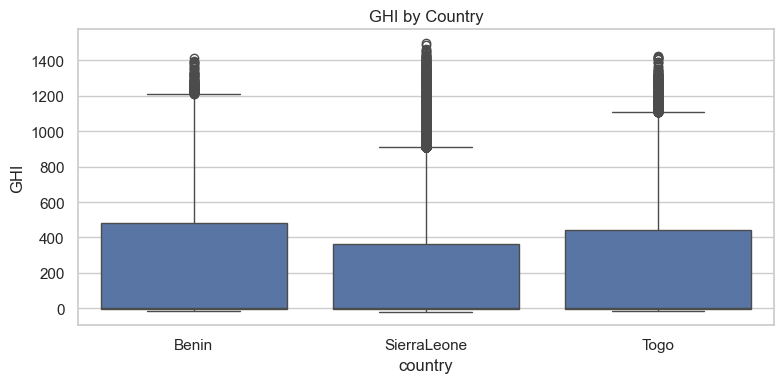

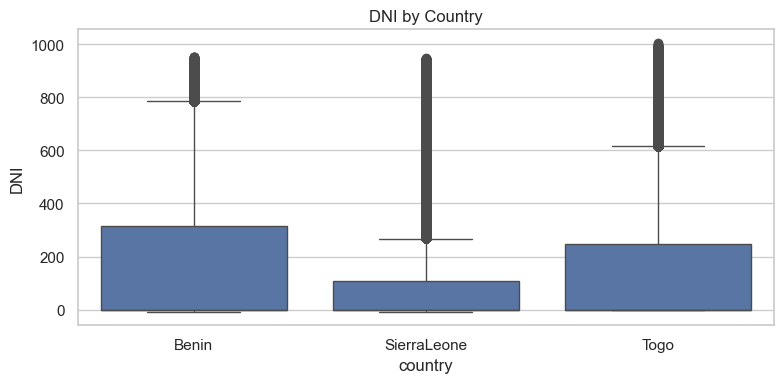

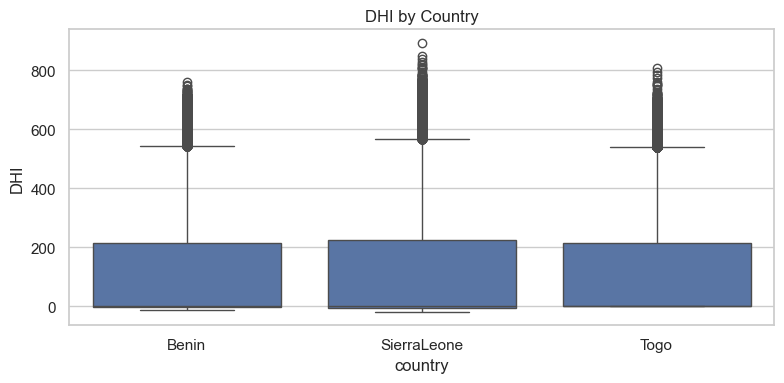

In [5]:
if not combined.empty:
    for metric in ['GHI','DNI','DHI']:
        if metric in combined.columns:
            plt.figure(figsize=(8,4))
            sns.boxplot(data=combined, x='country', y=metric)
            plt.title(f'{metric} by Country')
            plt.tight_layout()
            plt.show()
        else:
            print(metric, 'not present in data')
else:
    print('No combined data to plot')

## Statistical testing: One-way ANOVA on GHI (and Kruskal–Wallis if assumptions not met)

In [7]:
if combined.empty or 'GHI' not in combined.columns:
    print('Cannot run tests: GHI missing or no data')
else:
    groups = [df['GHI'].dropna().values for name, df in dfs.items() if not df.empty and 'GHI' in df.columns]
    names = [name for name, df in dfs.items() if not df.empty and 'GHI' in df.columns]
    if len(groups) < 2:
        print('Not enough groups for ANOVA/Kruskal test')
    else:
        fstat, pval = stats.f_oneway(*groups)
        print('ANOVA F =', round(fstat,4), 'p-value =', pval)
        kw_stat, kw_p = stats.kruskal(*groups)
        print('Kruskal-Wallis H =', round(kw_stat,4), 'p-value =', kw_p)
        for n, g in zip(names, groups):
            print(n, 'mean GHI =', round(np.nanmean(g),2), 'n=', len(g))

ANOVA F = 2090.0929 p-value = 0.0
Kruskal-Wallis H = 4524.8835 p-value = 0.0
Benin mean GHI = 240.56 n= 525600
SierraLeone mean GHI = 201.96 n= 525600
Togo mean GHI = 230.56 n= 525600


## Visual summary: ranking by average GHI

C:\Users\nesre\AppData\Local\Temp\ipykernel_13556\1060843374.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=mean_ghi.index, y=mean_ghi.values, palette='viridis')


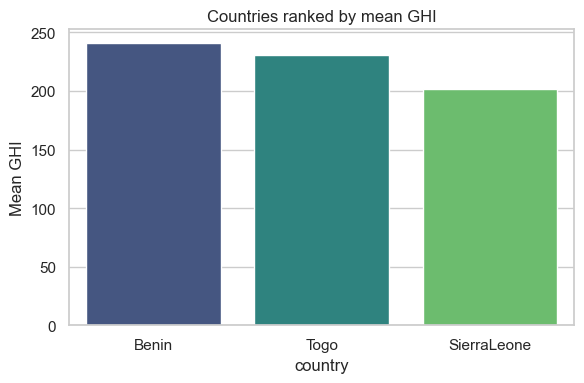

In [8]:
if not combined.empty and 'GHI' in combined.columns:
    mean_ghi = combined.groupby('country')['GHI'].mean().sort_values(ascending=False)
    plt.figure(figsize=(6,4))
    sns.barplot(x=mean_ghi.index, y=mean_ghi.values, palette='viridis')
    plt.ylabel('Mean GHI')
    plt.title('Countries ranked by mean GHI')
    plt.tight_layout()
    plt.show()
else:
    print('No GHI available to compute ranking')

## Key observations (brief)
- These with 2–3 bullets summarizing: which country has highest mean GHI, whether distributions differ, and statistical test outcome.